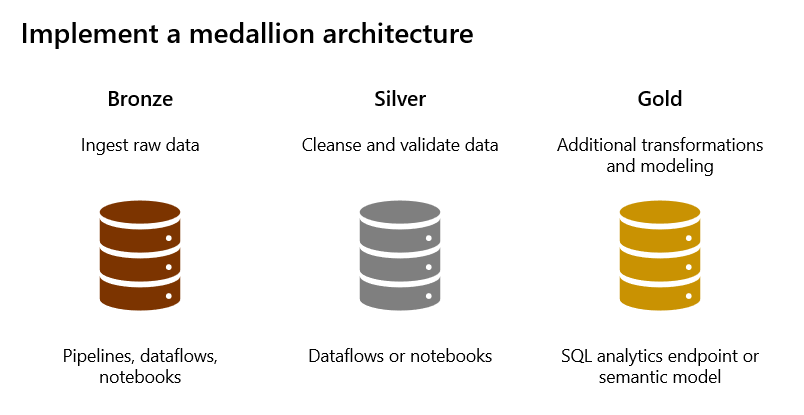

# Bronze Layer

##### Load libraries and define variable(s) values

In [ ]:
from pyspark.sql.types import *

bronze_dir = "Files/medallion/bronze/*.csv"

##### Read all csv file from **Bronze** folder directory

In [2]:
# Create the schema for the table
orderSchema = StructType([
    StructField("SalesOrderNumber", StringType()),
    StructField("SalesOrderLineNumber", IntegerType()),
    StructField("OrderDate", DateType()),
    StructField("CustomerName", StringType()),
    StructField("Email", StringType()),
    StructField("Item", StringType()),
    StructField("Quantity", IntegerType()),
    StructField("UnitPrice", FloatType()),
    StructField("Tax", FloatType())
])
    
# Import all files from bronze folder of lakehouse
df_bronze = (
    spark.read.format("csv")\
            .option("header", "true")\
            .schema(orderSchema)\
            .load(bronze_dir)
)

    
 # Display the first 10 rows of the dataframe to preview your data
display(df_bronze.head(5)) 


StatementMeta(, 027be6bf-b745-409d-bab4-d8e81f1c18d6, 4, Finished, Available)

SynapseWidget(Synapse.DataFrame, a04d04e3-26d1-40a4-aabd-91e888412ae2)

### Remember, it’s always a good practice to explore and understand your data before proceeding with any kind of data analysis or modeling.

The `summary()` function is used to generate descriptive statistics of a DataFrame. It provides a high-level summary and helps in understanding the distribution of different columns in the DataFrame. Here’s what it does:

- **Central Tendency:** It calculates measures of central tendency like mean, median, and mode for each column in the DataFrame.
Dispersion: It calculates measures of dispersion like standard deviation, variance, minimum and maximum values, and quartiles (25%, 50%, and 75%).
- **Count:** It provides the count of non-null values in each column.
- **Data Type:** It gives the data type of each column.
This function is particularly useful in the exploratory data analysis phase where you want to understand the underlying patterns in your data, identify outliers, and make hypotheses for further analysis123.

Please note that the exact statistics generated by `summary()` can vary depending on the data type of the columns in your DataFrame. For example, for numeric columns, you might get the mean, median, and other numerical statistics. For categorical columns, you might get the count of distinct categories, etc.

In some libraries like Pandas in Python, similar functionality is provided by the `describe()` function.

##### Get Statistical Information along with Quartile Information about your DataFrame.

In [3]:
#quartile information (25%, 50%, and 75%)
df_bronze.select("SalesOrderNumber", "SalesOrderLineNumber", "OrderDate", "Quantity", "UnitPrice", "Tax").summary().show()

#df_bronze.summary().show()
#display(df_bronze.select("SalesOrderNumber","SalesOrderLineNumber","OrderDate","Quantity","UnitPrice","Tax").describe())

StatementMeta(, 027be6bf-b745-409d-bab4-d8e81f1c18d6, 5, Finished, Available)

+-------+----------------+--------------------+--------------------+------------------+-----------------+
|summary|SalesOrderNumber|SalesOrderLineNumber|            Quantity|         UnitPrice|              Tax|
+-------+----------------+--------------------+--------------------+------------------+-----------------+
|  count|           32715|               32715|               32715|             32715|            32715|
|   mean|            null|   1.813663457129757|                 1.0|   639.51526513217|51.16122212253651|
| stddev|            null|  1.0051237026346864|3.709011772679747...|1071.9454951780597|85.75564001513405|
|    min|         SO43697|                   1|                   1|              2.29|           0.1832|
|    25%|            null|                   1|                   1|              8.99|           0.7192|
|    50%|            null|                   1|                   1|             34.99|           2.7992|
|    75%|            null|                   2

### Here, We are checking for null or blank values.

In [4]:
from pyspark.sql import functions as F

# Check for nulls or empty strings in each column
for col in df_bronze.columns:
    null_or_blank_count = df_bronze.filter((F.col(col).isNull()) | (F.trim(F.col(col)) == "")).count()
    if null_or_blank_count > 0:
        print(f"The column '{col}' has {null_or_blank_count} null or blank values.")
    else:
        print(f"The column '{col}' has no null or blank values.")


StatementMeta(, 027be6bf-b745-409d-bab4-d8e81f1c18d6, 6, Finished, Available)

The column 'SalesOrderNumber' has no null or blank values.
The column 'SalesOrderLineNumber' has no null or blank values.
The column 'OrderDate' has no null or blank values.
The column 'CustomerName' has no null or blank values.
The column 'Email' has no null or blank values.
The column 'Item' has no null or blank values.
The column 'Quantity' has no null or blank values.
The column 'UnitPrice' has no null or blank values.
The column 'Tax' has no null or blank values.


### Data Transformation
##### During data transformation for auditing, data partitioning, and error tracking, we might need the file names, especially if we are dealing with multiple files.

The `input_file_name()` function is used in PySpark to retrieve the name of the file from which each row of a DataFrame was loaded. 

This can be useful in several scenarios:
- **Data Provenance:** If your DataFrame is created by reading data from multiple files, you might want to keep track of the source file for each row for auditing or debugging purposes.

- **Data Partitioning:** If your data files are partitioned by certain criteria (for example, date), the file name often contains this partitioning information. By extracting the file name, you can obtain this partitioning information without having to store it in the data itself.

- **Error Tracking:** If some rows of data have errors, knowing which file the erroneous data came from can help you identify and fix issues with your data collection or processing methods.

##### Remember, since DataFrame in Spark is immutable (i.e., it does not allow changes to the data once it is created), `withColumn()` operation creates a new DataFrame with an added/updated column and reassigns it to the original DataFrame variable.

The `withColumn()` function is a transformation operation in PySpark used to change the value, convert the datatype of an existing column, create a new column, or rename a column.

Here's a breakdown of its usage:

1. **Change the value of an existing column**: You can use `withColumn()` to change the values of an existing column based on a condition. For example, `df.withColumn("age", df["age"] + 1)` will increase the value of the "age" column by 1 for all rows.

2. **Convert the datatype of an existing column**: You can use `withColumn()` to change the datatype of an existing column. For example, `df.withColumn("age", df["age"].cast(IntegerType()))` will change the datatype of the "age" column to integer.

3. **Create a new column**: You can use `withColumn()` to create a new column based on an existing one. For example, `df.withColumn("isAdult", df["age"] > 18)` will create a new column "isAdult" that is `True` if the "age" is greater than 18 and `False` otherwise.

4. **Rename a column**: Although `withColumnRenamed()` is typically used to rename a column, you can also use `withColumn()` for this purpose by creating a new column with the new name and dropping the old column.

In the script provided, `withColumn()` is used to create new columns ("FileName", "IsFlagged", "CreatedTS", "ModifiedTS") and update the values in an existing column ("CustomerName").

In [5]:
from pyspark.sql.functions import when, lit, col, current_timestamp, input_file_name

# Add columns IsFlagged, CreatedTS and ModifiedTS
df = df_bronze.withColumn("FileName", input_file_name()) \
              .withColumn("IsFlagged", when(col("OrderDate") < '2019-08-01',True).otherwise(False)) \
              .withColumn("CreatedTS", current_timestamp())\
              .withColumn("ModifiedTS", current_timestamp())

# Update CustomerName to "Unknown" if CustomerName null or empty
df_Updates_from_bronze = df.withColumn("CustomerName", 
                              when((col("CustomerName").isNull() | (col("CustomerName")=="")),lit("Unknown"))\
                              .otherwise(col("CustomerName")))

display(df_Updates_from_bronze.limit(3))

StatementMeta(, 027be6bf-b745-409d-bab4-d8e81f1c18d6, 7, Finished, Available)

SynapseWidget(Synapse.DataFrame, 66db7a45-a9f8-430c-9c73-c836e569fc76)

# Silver Layer
- In the Medallion architecture, the `Silver layer` is where data from the `Bronze layer` is matched, merged, conformed, and cleansed. 

- The `Silver layer` can provide an `Enterprise view` of all its key business entities, concepts, and transactions1. This includes master customers, stores, non-duplicated transactions, and cross-reference tables.

- From a data modeling perspective, the `Silver Layer` has more 3rd-Normal Form like data models1. Data Vault-like, write-performant data models can be used in this layer. So, it can be considered as a cleaned transactional layer in a normalized schema modeling. However, the exact structure and normalization of the data can vary depending on the specific requirements of your use case.

- It’s important to note that the `Silver layer` is typically loaded with minimal or `just-enough` transformations and data cleansing rules, prioritizing speed and agility to ingest and deliver the data in the data lake1. More complex transformations and business rules are often applied while loading the data from the Silver to Gold layer

### Sliver Layer - Data Transformation
In the `Medallion architecture`, the `Silver layer` plays a crucial role in data standardization and validation. 

Here's a detailed explanation:

1. **Standardization**: The Silver layer is where we apply standardization to our source datasets. This standardization aligns field names across sources, applies common data cleaning operations, and organizes the data into a well-known structure.

2. **Validation and Deduplication**: The Silver layer represents a validated, enriched version of our data that can be trusted for downstream analytics. The raw data from the Bronze layer has been **cleansed**, **standardized**, and **structured** as tables (rows and columns). It might also be integrated with other data to provide an enterprise view of all business entities.

3. **Foundation for Gold Layer**: The Silver layer provides the foundation for the Gold layer, where we may have many projections of the Silver data in different forms and at different granularities, depending on the downstream need.

4. **Data Granularity**: The Silver layer is generally stored at full-fidelity, i.e., the granularity of the data is the same in the Silver layer as it is in the Bronze layer.

In summary, the Silver layer in the Medallion architecture is the stage where raw data is transformed into a more usable and standardized format, ready for further analysis and insights extraction. It serves as a bridge between the raw data ingestion (Bronze) and the final data product (Gold).

#### Define the schema for the sales_silver table

In [6]:
from pyspark.sql.types import *
from pyspark.sql import SparkSession

df_silver_table_name = "sales_silver"

delta_Table_Dir = F"Files/medallion/silver/{df_silver_table_name}"

# Define the schema
schema = StructType([
    StructField("SalesOrderNumber", StringType()),
    StructField("SalesOrderLineNumber", IntegerType()),
    StructField("OrderDate", DateType()),
    StructField("CustomerName", StringType()),
    StructField("Email", StringType()),
    StructField("Item", StringType()),
    StructField("Quantity", IntegerType()),
    StructField("UnitPrice", FloatType()),
    StructField("Tax", FloatType()),
    StructField("FileName", StringType()),
    StructField("IsFlagged", BooleanType()),
    StructField("CreatedTS", DateType()),
    StructField("ModifiedTS", DateType())
])

# Create an empty DataFrame with the schema
df = spark.createDataFrame([], schema)

# Write the DataFrame to a location with the format "delta"
df.write.format("delta")\
  .mode("overwrite")\
  .option("path", delta_Table_Dir)\
  .saveAsTable(df_silver_table_name)

StatementMeta(, 027be6bf-b745-409d-bab4-d8e81f1c18d6, 8, Finished, Available)

In [7]:
spark.catalog.listTables()

StatementMeta(, 027be6bf-b745-409d-bab4-d8e81f1c18d6, 9, Finished, Available)

[Table(name='dp_600_demo', catalog='spark_catalog', namespace=['lh01'], description=None, tableType='MANAGED', isTemporary=False),
 Table(name='sales_silver', catalog='spark_catalog', namespace=['lh01'], description=None, tableType='EXTERNAL', isTemporary=False)]

#### We could have created silver table like this as well.

In [ ]:
 # Define the schema for the sales_silver table
    
from pyspark.sql.types import *
from delta.tables import *

DeltaTable.createIfNotExists(spark) \
    .tableName("lh01.sales_silver2") \
    .addColumn("SalesOrderNumber", StringType()) \
    .addColumn("SalesOrderLineNumber", IntegerType()) \
    .addColumn("OrderDate", DateType()) \
    .addColumn("CustomerName", StringType()) \
    .addColumn("Email", StringType()) \
    .addColumn("Item", StringType()) \
    .addColumn("Quantity", IntegerType()) \
    .addColumn("UnitPrice", FloatType()) \
    .addColumn("Tax", FloatType()) \
    .addColumn("FileName", StringType()) \
    .addColumn("IsFlagged", BooleanType()) \
    .addColumn("CreatedTS", DateType()) \
    .addColumn("ModifiedTS", DateType()) \
    .execute()

In [8]:
%%sql
SELECT *
FROM lh01.sales_silver
LIMIT 3;

StatementMeta(, 027be6bf-b745-409d-bab4-d8e81f1c18d6, 10, Finished, Available)

<Spark SQL result set with 0 rows and 13 fields>

#### Now, let’s load the data that we just cleaned from the Bronze layer into the Silver layer.

In [9]:
# Update existing records and insert new ones based on a condition defined by the columns SalesOrderNumber, OrderDate, CustomerName, and Item.

from delta.tables import *
    
deltaTable = DeltaTable.forPath(spark, 'Files/medallion/silver/sales_silver')
    
dfUpdates = df_Updates_from_bronze
    
deltaTable.alias('silver') \
  .merge(
    dfUpdates.alias('updates'),
    'silver.SalesOrderNumber = updates.SalesOrderNumber\
        and silver.OrderDate = updates.OrderDate\
        and silver.CustomerName = updates.CustomerName\
        and silver.Item = updates.Item'
  ) \
   .whenMatchedUpdate(set =
    {
          
    }
  ) \
 .whenNotMatchedInsert(values =
    {
      "SalesOrderNumber": "updates.SalesOrderNumber",
      "SalesOrderLineNumber": "updates.SalesOrderLineNumber",
      "OrderDate": "updates.OrderDate",
      "CustomerName": "updates.CustomerName",
      "Email": "updates.Email",
      "Item": "updates.Item",
      "Quantity": "updates.Quantity",
      "UnitPrice": "updates.UnitPrice",
      "Tax": "updates.Tax",
      "FileName": "updates.FileName",
      "IsFlagged": "updates.IsFlagged",
      "CreatedTS": "updates.CreatedTS",
      "ModifiedTS": "updates.ModifiedTS"
    }
  ) \
  .execute()

StatementMeta(, 027be6bf-b745-409d-bab4-d8e81f1c18d6, 11, Finished, Available)

#### The Silver Layer Table can be queried using a `notebook` and/or the `SQL Endpoint`.

In [10]:
%%sql
 SELECT YEAR(OrderDate) AS Year
     , CAST (SUM(Quantity * (UnitPrice + Tax)) AS DECIMAL(12, 2)) AS TotalSales
 FROM sales_silver
 GROUP BY YEAR(OrderDate) 
 ORDER BY YEAR(OrderDate)

StatementMeta(, 027be6bf-b745-409d-bab4-d8e81f1c18d6, 12, Finished, Available)

<Spark SQL result set with 3 rows and 2 fields>

# Gold layer
- In the Medallion architecture, the `Gold layer` is where data is organized into **consumption-ready, function-specific databases**. 

- This layer is for reporting and uses more denormalized and read-optimized data models with fewer joins. The `Gold layer` contains **data that has been transformed into knowledge, rather than just information**. 

- The Gold data is often highly refined and aggregated, containing data that powers analytics, machine learning, and production applications.

- So, the Gold layer in the Medallion architecture is mainly used for business aggregation and knowledge-based tasks. However, the exact structure and normalization of the data can vary depending on the specific requirements of your use case.

#### Now, let’s transform the data from the **Silver layer** and save it into the **Gold layer** folder directory.

In [11]:
 # Load data to the dataframe as a starting point to create the gold layer
 df_silver_sales_ds = spark.read.table("lh01.sales_silver")

 display(df_silver_sales_ds.limit(3))

StatementMeta(, 027be6bf-b745-409d-bab4-d8e81f1c18d6, 13, Finished, Available)

SynapseWidget(Synapse.DataFrame, 681975cd-99a6-4aa5-8135-f2fcc004474a)

### Let's create the Gold Layer Tables
- DimCustomer
- DimDate
- DimProduct
- FactSales

### DimDate
- Let's create DimDate Table

In [12]:
from pyspark.sql.types import *
from pyspark.sql import SparkSession

df_silver_table_name = "DimDate"

delta_Table_Dir = "Files/medallion/gold/DimDate/"

# Define the schema
schema = StructType([
    StructField("OrderDate", DateType()),
    StructField("Day", IntegerType()),
    StructField("Month", IntegerType()),
    StructField("Year", IntegerType()),
    StructField("mmmyyyy", StringType()),
    StructField("yyyymm", StringType())
])

# Create an empty DataFrame with the schema
df = spark.createDataFrame([], schema)

# Write the DataFrame to a location with the format "delta"
df.write.format("delta")\
  .mode("overwrite")\
  .option("path", delta_Table_Dir)\
  .saveAsTable(df_silver_table_name)

StatementMeta(, 027be6bf-b745-409d-bab4-d8e81f1c18d6, 14, Finished, Available)

In [13]:
%%sql
SELECT *
FROM DimDate
LIMIT 3;

StatementMeta(, 027be6bf-b745-409d-bab4-d8e81f1c18d6, 15, Finished, Available)

<Spark SQL result set with 0 rows and 6 fields>

Let's populate the data for the DimDate Table

In [14]:
from pyspark.sql.functions import col, dayofmonth, month, year, date_format

# Create dataframe for dimDate_gold

df_DimDate_Gold = df_silver_sales_ds.dropDuplicates(["OrderDate"]).select(col("OrderDate"), \
        dayofmonth("OrderDate").alias("Day"), \
        month("OrderDate").alias("Month"), \
        year("OrderDate").alias("Year"), \
        date_format(col("OrderDate"), "MMM-yyyy").alias("mmmyyyy"), \
        date_format(col("OrderDate"), "yyyyMM").alias("yyyymm"), \
    ).orderBy("OrderDate")

# Display the first 10 rows of the dataframe to preview your data

display(df_DimDate_Gold.head(3))

StatementMeta(, 027be6bf-b745-409d-bab4-d8e81f1c18d6, 16, Finished, Available)

SynapseWidget(Synapse.DataFrame, a5e51916-a4c2-4bce-9e9e-d5a80f6aca98)

Let's insert the data into DimDate Table

In [15]:
from delta.tables import *

deltaTable = DeltaTable.forPath(spark, 'Files/medallion/gold/DimDate')

dfUpdates = df_DimDate_Gold

deltaTable.alias('silver') \
.merge(
    dfUpdates.alias('updates'),
    'silver.OrderDate = updates.OrderDate'
) \
.whenMatchedUpdate(set =
    {
        
    }
) \
.whenNotMatchedInsert(values =
    {
    "OrderDate": "updates.OrderDate",
    "Day": "updates.Day",
    "Month": "updates.Month",
    "Year": "updates.Year",
    "mmmyyyy": "updates.mmmyyyy",
    "yyyymm": "yyyymm"
    }
) \
.execute()

StatementMeta(, 027be6bf-b745-409d-bab4-d8e81f1c18d6, 17, Finished, Available)

In [16]:
%%sql
SELECT *
FROM DimDate
LIMIT 3;

StatementMeta(, 027be6bf-b745-409d-bab4-d8e81f1c18d6, 18, Finished, Available)

<Spark SQL result set with 3 rows and 6 fields>

### DimCustomer
- Let's create DimCustomer Table

In [17]:
from pyspark.sql.types import *
from pyspark.sql import SparkSession

df_silver_table_name = "DimCustomer"

delta_Table_Dir = "Files/medallion/gold/DimCustomer/"

# Define the schema
schema = StructType([
    StructField("CustomerName", StringType()),
    StructField("Email", StringType()),
    StructField("First", StringType()),
    StructField("Last", StringType()),
    StructField("CustomerID", LongType())
])


# Create an empty DataFrame with the schema
df = spark.createDataFrame([], schema)

# Write the DataFrame to a location with the format "delta"
df.write.format("delta")\
  .mode("overwrite")\
  .option("path", delta_Table_Dir)\
  .saveAsTable(df_silver_table_name)

StatementMeta(, 027be6bf-b745-409d-bab4-d8e81f1c18d6, 19, Finished, Available)

In [18]:
%%sql
SELECT *
FROM DimCustomer
LIMIT 3;

StatementMeta(, 027be6bf-b745-409d-bab4-d8e81f1c18d6, 20, Finished, Available)

<Spark SQL result set with 0 rows and 5 fields>

Let's get ready the data for the **DimCustomer** Table
- Notice that we kept `CustomerName` field name. We need it for next cell code

In [19]:
from pyspark.sql.functions import col, split

# Create customer_silver dataframe

df_dimCustomer_silver = df_silver_sales_ds.dropDuplicates(["CustomerName","Email"])\
    .select(col("CustomerName"),col("Email")) \
    .withColumn("First",split(col("CustomerName"), " ").getItem(0)) \
    .withColumn("Last",split(col("CustomerName"), " ").getItem(1)) 

# Display the first 10 rows of the dataframe to preview your data

display(df_dimCustomer_silver.head(3))

StatementMeta(, 027be6bf-b745-409d-bab4-d8e81f1c18d6, 21, Finished, Available)

SynapseWidget(Synapse.DataFrame, 5c208d99-6fe0-4517-86cd-524a4d11a700)

Let's bring `CustomerId` with the help of `CustomerName` Field

In [20]:
from pyspark.sql.functions import monotonically_increasing_id, col, when, coalesce, max, lit

dfdimCustomer_temp = spark.read.table("DimCustomer")

MAXCustomerID = dfdimCustomer_temp.select(coalesce(max(col("CustomerID")),lit(0))\
                                  .alias("MAXCustomerID"))\
                                  .first()[0]

dfdimCustomer_gold = df_dimCustomer_silver.join(
    dfdimCustomer_temp,(df_dimCustomer_silver.CustomerName == dfdimCustomer_temp.CustomerName)\
     & (df_dimCustomer_silver.Email == dfdimCustomer_temp.Email), "left_anti")

dfdimCustomer_gold = dfdimCustomer_gold.withColumn("CustomerID",monotonically_increasing_id() + MAXCustomerID + 1)

# Display the first 10 rows of the dataframe to preview your data

display(dfdimCustomer_gold.head(3))

StatementMeta(, 027be6bf-b745-409d-bab4-d8e81f1c18d6, 22, Finished, Available)

SynapseWidget(Synapse.DataFrame, 1440b088-a7a5-4724-ab46-c74a1c6c3f25)

Let's insert the data into DimCustomer Table

In [21]:
from delta.tables import *

deltaTable = DeltaTable.forPath(spark, 'Files/medallion/gold/DimCustomer')
    
dfUpdates = dfdimCustomer_gold
    
deltaTable.alias('silver') \
  .merge(
    dfUpdates.alias('updates'),
    'silver.CustomerName = updates.CustomerName AND silver.Email = updates.Email'
  ) \
   .whenMatchedUpdate(set =
    {
          
    }
  ) \
 .whenNotMatchedInsert(values =
    {
      "CustomerName": "updates.CustomerName",
      "Email": "updates.Email",
      "First": "updates.First",
      "Last": "updates.Last",
      "CustomerID": "updates.CustomerID"
    }
  ) \
  .execute()

StatementMeta(, 027be6bf-b745-409d-bab4-d8e81f1c18d6, 23, Finished, Available)

In [22]:
%%sql
SELECT *
FROM dimcustomer
LIMIT 3;

StatementMeta(, 027be6bf-b745-409d-bab4-d8e81f1c18d6, 24, Finished, Available)

<Spark SQL result set with 3 rows and 5 fields>

### DimProdut
- Let's create DimProduct Table

In [23]:
from pyspark.sql.types import *
from pyspark.sql import SparkSession

df_silver_table_name = "DimProduct"

delta_Table_Dir = "Files/medallion/gold/DimProduct/"

# Define the schema
schema = StructType([
    StructField("ItemName", StringType()),
    StructField("ItemID", LongType()),
    StructField("ItemInfo", StringType())
])


# Create an empty DataFrame with the schema
df = spark.createDataFrame([], schema)

# Write the DataFrame to a location with the format "delta"
df.write.format("delta")\
  .mode("overwrite")\
  .option("path", delta_Table_Dir)\
  .saveAsTable(df_silver_table_name)

StatementMeta(, 027be6bf-b745-409d-bab4-d8e81f1c18d6, 25, Finished, Available)

In [24]:
%%sql
SELECT * 
FROM DimProduct
LIMIT 3;

StatementMeta(, 027be6bf-b745-409d-bab4-d8e81f1c18d6, 26, Finished, Available)

<Spark SQL result set with 0 rows and 3 fields>

Let's get ready the data for the **DimProduct** Table

In [25]:
from pyspark.sql.functions import col, split, lit
    
# Create product_silver dataframe
    
dfdimProduct_silver = df_silver_sales_ds.dropDuplicates(["Item"]).select(col("Item")) \
    .withColumn("ItemName",split(col("Item"), ", ").getItem(0)) \
    .withColumn("ItemInfo",when((split(col("Item"), ", ").getItem(1).isNull()\
     | (split(col("Item"), ", ").getItem(1)=="")),lit("")).otherwise(split(col("Item"), ", ").getItem(1))) 
    
# Display the first 3 rows of the dataframe to preview your data

display(dfdimProduct_silver.head(3))

StatementMeta(, 027be6bf-b745-409d-bab4-d8e81f1c18d6, 27, Finished, Available)

SynapseWidget(Synapse.DataFrame, 7793d972-d200-46e5-b50b-9784e8667a3c)

Let's bring `ItemId` field

In [26]:
from pyspark.sql.functions import monotonically_increasing_id, col, lit, max, coalesce
    
#dfdimProduct_temp = dfdimProduct_silver
dfdimProduct_temp = spark.read.table("DimProduct")
    
MAXProductID = dfdimProduct_temp.select(coalesce(max(col("ItemID")),lit(0)).alias("MAXItemID")).first()[0]
    
dfdimProduct_gold = dfdimProduct_silver.join(
    dfdimProduct_temp,(dfdimProduct_silver.ItemName == dfdimProduct_temp.ItemName)\
     & (dfdimProduct_silver.ItemInfo == dfdimProduct_temp.ItemInfo), "left_anti"
)
    
dfdimProduct_gold = dfdimProduct_gold.withColumn("ItemID",monotonically_increasing_id() + MAXProductID + 1)
    
# Display the first 3 rows of the dataframe to preview your data

display(dfdimProduct_gold.head(3))

StatementMeta(, 027be6bf-b745-409d-bab4-d8e81f1c18d6, 28, Finished, Available)

SynapseWidget(Synapse.DataFrame, 44f295f9-8392-4d87-a3f6-8711d3db15c9)

Let's insert the data into **DimProduct** Table

In [27]:
from delta.tables import *
    
deltaTable = DeltaTable.forPath(spark,'Files/medallion/gold/DimProduct')
            
dfUpdates = dfdimProduct_gold
            
deltaTable.alias('silver') \
  .merge(
        dfUpdates.alias('updates'),
        'silver.ItemName = updates.ItemName AND silver.ItemInfo = updates.ItemInfo'
        ) \
        .whenMatchedUpdate(set =
        {
               
        }
        ) \
        .whenNotMatchedInsert(values =
         {
          "ItemName": "updates.ItemName",
          "ItemInfo": "updates.ItemInfo",
          "ItemID": "updates.ItemID"
          }
          ) \
          .execute()

StatementMeta(, 027be6bf-b745-409d-bab4-d8e81f1c18d6, 29, Finished, Available)

In [28]:
%%sql
SELECT * 
FROM DimProduct
LIMIT 3;

StatementMeta(, 027be6bf-b745-409d-bab4-d8e81f1c18d6, 30, Finished, Available)

<Spark SQL result set with 3 rows and 3 fields>

# FactSales
- Let's create FactSales Table

In [29]:
from pyspark.sql.types import *
from pyspark.sql import SparkSession

df_silver_table_name = "FactSales"

delta_Table_Dir = "Files/medallion/gold/FactSales/"

# Define the schema
schema = StructType([
    StructField("CustomerID", LongType()),
    StructField("ItemID", LongType()),
    StructField("OrderDate", DateType()),
    StructField("Quantity", IntegerType()),
    StructField("UnitPrice", FloatType()),
    StructField("Tax", FloatType())
])


# Create an empty DataFrame with the schema
df = spark.createDataFrame([], schema)

# Write the DataFrame to a location with the format "delta"
df.write.format("delta")\
  .mode("overwrite")\
  .option("path", delta_Table_Dir)\
  .saveAsTable(df_silver_table_name)

StatementMeta(, 027be6bf-b745-409d-bab4-d8e81f1c18d6, 31, Finished, Available)

In [30]:
%%sql
SELECT *
FROM factsales
LIMIT 3

StatementMeta(, 027be6bf-b745-409d-bab4-d8e81f1c18d6, 32, Finished, Available)

<Spark SQL result set with 0 rows and 6 fields>

Let's get ready the data for the **FactSales** Table
- We need DimCustomer and DimProduct tables

In [31]:
from pyspark.sql.functions import col
    
dfdimCustomer_temp = spark.read.table("DimCustomer")
dfdimProduct_temp = spark.read.table("DimProduct")
    
df = df_silver_sales_ds.withColumn("ItemName",split(col("Item"), ", ").getItem(0)) \
    .withColumn("ItemInfo",when((split(col("Item"), ", ").getItem(1).isNull()\
     | (split(col("Item"), ", ").getItem(1)=="")),lit("")).otherwise(split(col("Item"), ", ").getItem(1))) \
    
    
# Create Sales_gold dataframe
    
dffactSales_gold = df.alias("df1")\
    .join(dfdimCustomer_temp.alias("df2"),(df.CustomerName == dfdimCustomer_temp.CustomerName)\
     & (df.Email == dfdimCustomer_temp.Email), "left") \
    .join(dfdimProduct_temp.alias("df3"),(df.ItemName == dfdimProduct_temp.ItemName)\
     & (df.ItemInfo == dfdimProduct_temp.ItemInfo), "left") \
    .select(col("df2.CustomerID") \
        , col("df3.ItemID") \
        , col("df1.OrderDate") \
        , col("df1.Quantity") \
        , col("df1.UnitPrice") \
        , col("df1.Tax") \
    ).orderBy(col("df1.OrderDate"), col("df2.CustomerID"), col("df3.ItemID"))
    
# Display the first 3 rows of the dataframe to preview your data
    
display(dffactSales_gold.head(3))

StatementMeta(, 027be6bf-b745-409d-bab4-d8e81f1c18d6, 33, Finished, Available)

SynapseWidget(Synapse.DataFrame, 2d84064e-373b-4840-b382-3a92b1485c32)

Let's insert the data into **FactSales** Table

In [32]:
from delta.tables import *
    
deltaTable = DeltaTable.forPath(spark, 'Files/medallion/gold/FactSales')
    
dfUpdates = dffactSales_gold
    
deltaTable.alias('silver') \
  .merge(
    dfUpdates.alias('updates'),
    'silver.OrderDate = updates.OrderDate AND silver.CustomerID = updates.CustomerID AND silver.ItemID = updates.ItemID'
  ) \
   .whenMatchedUpdate(set =
    {
          
    }
  ) \
 .whenNotMatchedInsert(values =
    {
      "CustomerID": "updates.CustomerID",
      "ItemID": "updates.ItemID",
      "OrderDate": "updates.OrderDate",
      "Quantity": "updates.Quantity",
      "UnitPrice": "updates.UnitPrice",
      "Tax": "updates.Tax"
    }
  ) \
  .execute()

StatementMeta(, 027be6bf-b745-409d-bab4-d8e81f1c18d6, 34, Finished, Available)

In [33]:
%%sql
SELECT *
FROM factsales
LIMIT 3

StatementMeta(, 027be6bf-b745-409d-bab4-d8e81f1c18d6, 35, Finished, Available)

<Spark SQL result set with 3 rows and 6 fields>

## Now, we can create a semantic model out of the Medallion Gold layer.